<a href="https://colab.research.google.com/github/tommyj530/Learning-based-comms-system-using-autoencoder-and-CGAN/blob/main/VAE_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGANAutoencoder-Based End-to-End Communications System
ELEC825 Machine Learning and Deep Learning @ Queen's University Kingston, ON

Author: Thomas Jung

Date: March 27, 2021

## CGAN for channel estimation
Train a GAN to mimik any unknown channel function.
Reference: https://wiseodd.github.io/techblog/2016/12/24/conditional-gan-tensorflow/ 

### Setup

#### Import libraries

In [ ]:
import glob
import imageio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # Ignore if you do not have multiple GPUs

import time 
from IPython import display
from tensorflow.keras import backend as K

In [ ]:
print(tf.__version__)

2.4.1


#### System parameters

In [ ]:
k = 8       # Number of information bits per message, i.e., M=2**k
n = 2    #changed from 8  # Number of real channel uses per message

#### Define real channel

Rayleigh distribution
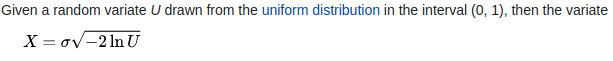


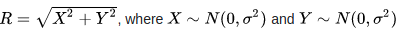

Rician distribution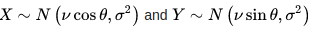

In [ ]:
def real_channel(x):
    # Black-box Channel
    #AWGN
    #return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)
    return x + tf.random.normal(shape=tf.shape(x)) * tf.cast(noise_std,dtype=tf.float32)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random.uniform(tf.shape(x), minval=-3, maxval=3)

VAE

In [ ]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

In [ ]:
train_SNR_dB =  15 
batch_size = 16
noise_std = EbNo2Sigma(train_SNR_dB) # should be able to vary this based on SNR
#number of neurons per layer
E_nb_weights = 32
D_nb_weights = 32

latent_dim = n


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
vae_inputs = keras.Input(shape=(n, ))
x = layers.Dense(E_nb_weights, activation="relu")(vae_inputs)
x = layers.Dense(E_nb_weights, activation="relu")(x)
x = layers.Dense(E_nb_weights, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

# latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(E_nb_weights, activation="relu",name="decod1")(z)
x = layers.Dense(E_nb_weights, activation="relu",name="decod2")(x)
x = layers.Dense(E_nb_weights, activation="relu",name="decod3")(x)
vae_outputs = layers.Dense(n, name="reconstruction")(x)
vae = keras.Model(vae_inputs, [vae_outputs,z_mean,z_log_var,z], name="vae")
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           96          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
________________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam()
#EPOCHS = 100
EPOCHS = 20
noise_dim = n 

In [ ]:
rv_simple = tf.random.normal([2, noise_dim])
dataa = real_channel(rv_simple)
print(dataa)
Recons,z_meann,_,_ = vae(dataa)
print(Recons)
print(z_meann)
# xx = tf.random.normal([2, latent_dim])
# print(vae.layers[7].name)
# yy = vae.layers[10](vae.layers[9](vae.layers[8](vae.layers[7](xx))))
# print(yy)

tf.Tensor(
[[ 1.8415745  2.1442676]
 [-0.7087769 -1.529525 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02791844  0.10885591]
 [ 0.02656225  0.113622  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.11968486  0.0328599 ]
 [ 0.03708988 -0.19907129]], shape=(2, 2), dtype=float32)


In [ ]:
def vae_loss(y_real, reconstruction, z_mean, z_log_var):
  reconstruction_loss = tf.reduce_mean(K.sum(K.square(y_real - reconstruction), axis=-1))
  kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
  kl_loss = 0.01*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
  total_loss = reconstruction_loss + kl_loss
  return total_loss, reconstruction_loss, kl_loss

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step():
  rv_simple = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as vae_tape:
    y_real = real_channel(rv_simple)
    # reconstruction, z_mean, z_log_var, z = vae(y_real)
    reconstruction, z_mean, z_log_var, z = vae(rv_simple) 

    total_loss, recons_loss, kl_loss = vae_loss(y_real, reconstruction, z_mean, z_log_var)

  gradients_of_vae = vae_tape.gradient(total_loss, vae.trainable_variables)

  optimizer.apply_gradients(zip(gradients_of_vae, vae.trainable_variables))

  return total_loss, recons_loss, kl_loss

In [ ]:
def test_step():
  #parameters
  hist_range = 3
  for i in range(1000):
    hist_range = 3
    rv_simple = tf.random.normal([batch_size, noise_dim])
    if i == 0:
      # recons = vae.layers[10](vae.layers[9](vae.layers[8](vae.layers[7](rv_simple))))
      recons,_,_,_ = vae(rv_simple)
      y_fake = np.array(recons)
      y_fake = y_fake.squeeze().tolist()
      y_real = np.array(real_channel(rv_simple))
      y_real = y_real.squeeze().tolist()
    else:
      # recons = vae.layers[10](vae.layers[9](vae.layers[8](vae.layers[7](rv_simple))))
      recons,_,_,_ = vae(rv_simple)
      temp = np.array(recons)
      temp = temp.squeeze().tolist()
      y_fake = np.append(y_fake,temp)
      temp = np.array(real_channel(rv_simple))
      temp = temp.squeeze().tolist()
      y_real = np.append(y_real,temp)

  #and plot results  
  plt.hist(y_fake,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')   
  plt.hist(y_real,bins=100,range=(-hist_range,hist_range),density=True,histtype='step') 
  plt.title("channel distribution")
  plt.legend(["VAE", "target"])
  plt.show()

In [ ]:
checkpoint_dir = 'Desktop/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,vae=vae,)

In [ ]:
def train(epochs):
  gen_loss_prior = 0
  count = 0
  for epoch in range(epochs):
    start = time.time()
    for i in range(1000):
      total_loss, recons_loss, kl_loss = train_step()
    
    if epoch%2==0:
      test_step()

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('VAE Loss: {}, reconstruction loss: {}, kl loss: {}'.format(total_loss, recons_loss, kl_loss))
    print('-----------------------------------------------------------------')
# Save the model at the end
checkpoint.save('Desktop/checkpoint')


'Desktop/checkpoint-1'

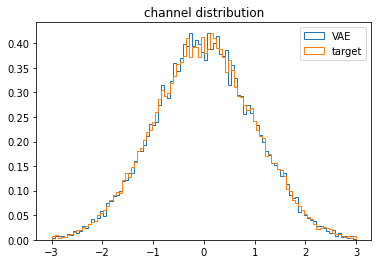

Time for epoch 1 is 6.621678829193115 sec
VAE Loss: 0.06424619257450104, reconstruction loss: 0.00999472662806511, kl loss: 0.05425146594643593
-----------------------------------------------------------------
Time for epoch 2 is 0.9801151752471924 sec
VAE Loss: 0.06449638307094574, reconstruction loss: 0.013882584869861603, kl loss: 0.05061379447579384
-----------------------------------------------------------------


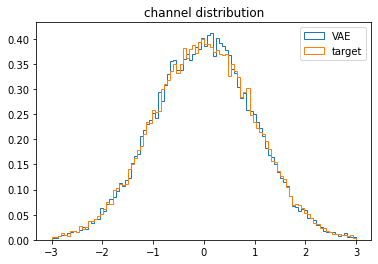

Time for epoch 3 is 5.458196640014648 sec
VAE Loss: 0.07529287040233612, reconstruction loss: 0.018634771928191185, kl loss: 0.056658096611499786
-----------------------------------------------------------------
Time for epoch 4 is 0.890451192855835 sec
VAE Loss: 0.062360040843486786, reconstruction loss: 0.006526870187371969, kl loss: 0.05583317205309868
-----------------------------------------------------------------


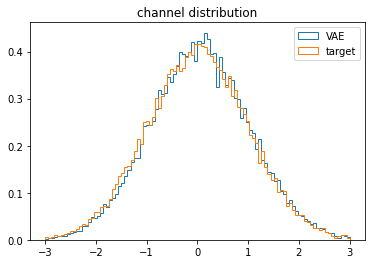

Time for epoch 5 is 5.4160778522491455 sec
VAE Loss: 0.06315939128398895, reconstruction loss: 0.012878350913524628, kl loss: 0.050281036645174026
-----------------------------------------------------------------
Time for epoch 6 is 0.8992347717285156 sec
VAE Loss: 0.06183691322803497, reconstruction loss: 0.013478501699864864, kl loss: 0.048358410596847534
-----------------------------------------------------------------


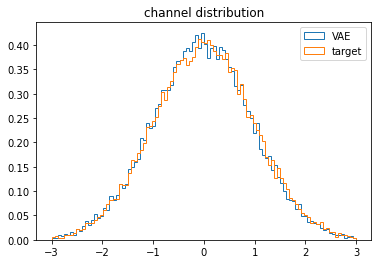

Time for epoch 7 is 5.445626497268677 sec
VAE Loss: 0.07060962170362473, reconstruction loss: 0.015608505345880985, kl loss: 0.055001113563776016
-----------------------------------------------------------------
Time for epoch 8 is 0.9234428405761719 sec
VAE Loss: 0.07325766980648041, reconstruction loss: 0.018112119287252426, kl loss: 0.05514554679393768
-----------------------------------------------------------------


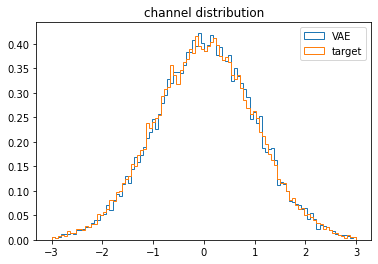

Time for epoch 9 is 5.450620412826538 sec
VAE Loss: 0.059790853410959244, reconstruction loss: 0.009732632897794247, kl loss: 0.05005821958184242
-----------------------------------------------------------------
Time for epoch 10 is 0.9117417335510254 sec
VAE Loss: 0.06677475571632385, reconstruction loss: 0.015992363914847374, kl loss: 0.05078238993883133
-----------------------------------------------------------------


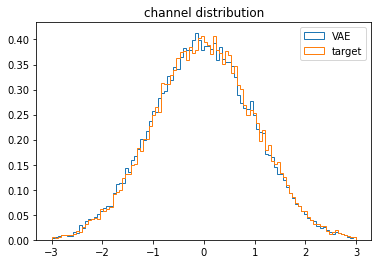

Time for epoch 11 is 5.422725439071655 sec
VAE Loss: 0.07067298144102097, reconstruction loss: 0.00886654295027256, kl loss: 0.061806440353393555
-----------------------------------------------------------------
Time for epoch 12 is 0.9014298915863037 sec
VAE Loss: 0.07105417549610138, reconstruction loss: 0.016609160229563713, kl loss: 0.054445017129182816
-----------------------------------------------------------------


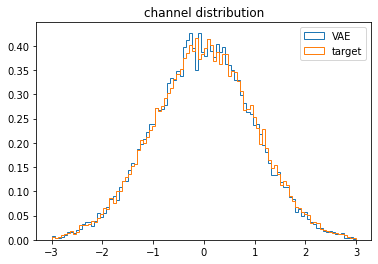

Time for epoch 13 is 5.515771865844727 sec
VAE Loss: 0.060714948922395706, reconstruction loss: 0.01110436487942934, kl loss: 0.04961058497428894
-----------------------------------------------------------------
Time for epoch 14 is 0.9201984405517578 sec
VAE Loss: 0.07372459769248962, reconstruction loss: 0.02232612669467926, kl loss: 0.05139847472310066
-----------------------------------------------------------------


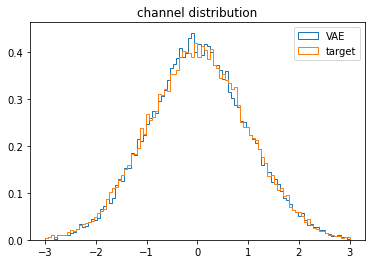

Time for epoch 15 is 5.373227596282959 sec
VAE Loss: 0.06904549896717072, reconstruction loss: 0.016055773943662643, kl loss: 0.05298972874879837
-----------------------------------------------------------------
Time for epoch 16 is 0.910768985748291 sec
VAE Loss: 0.060395512729883194, reconstruction loss: 0.010361850261688232, kl loss: 0.05003366246819496
-----------------------------------------------------------------


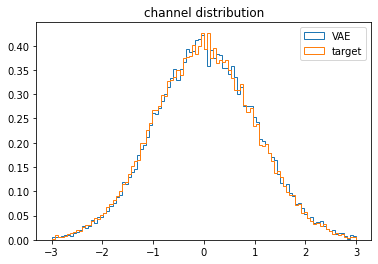

Time for epoch 17 is 5.392074108123779 sec
VAE Loss: 0.06772668659687042, reconstruction loss: 0.011120635084807873, kl loss: 0.05660605430603027
-----------------------------------------------------------------
Time for epoch 18 is 0.908921480178833 sec
VAE Loss: 0.06509845703840256, reconstruction loss: 0.014076557010412216, kl loss: 0.05102190002799034
-----------------------------------------------------------------


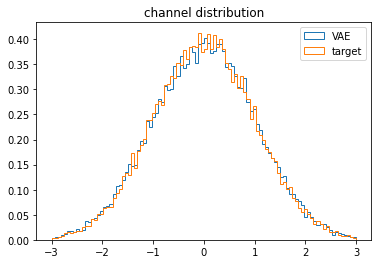

Time for epoch 19 is 5.425377607345581 sec
VAE Loss: 0.06372994184494019, reconstruction loss: 0.010672660544514656, kl loss: 0.05305728316307068
-----------------------------------------------------------------
Time for epoch 20 is 0.8967649936676025 sec
VAE Loss: 0.06473475694656372, reconstruction loss: 0.014326423406600952, kl loss: 0.05040833353996277
-----------------------------------------------------------------


In [ ]:
train(EPOCHS)

### Autoencoder parameters

In [ ]:
k = 4                               # bit per autoencoder message
M = 2**k                            # total nb of autoencoder messages  

### The Encoder / Transmitter

In [ ]:
encoder_input = tf.keras.Input(shape=(), dtype=tf.int32, name='enc_in')
one_hot = tf.one_hot(encoder_input,depth=M)
x = tf.keras.layers.Dense(128,activation="relu")(one_hot)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dense(n,activation=None)(x)
encoder_output = x / tf.sqrt(tf.reduce_mean(tf.square(x)))    # batch normalization to limit average signal power to 1.0 (per complex channel use)
encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
tf.one_hot (TFOpLambda)         (None, 16)           0           enc_in[0][0]                     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          2176        tf.one_hot[0][0]                 
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
____________________________________________________________________________________________

#### Test the transmitter 
Generate signals for a batch of all possible M messages and have a look at the encoded signals

In [ ]:
x = encoder(np.arange(M,dtype=np.int32)).numpy()
print(x)
print(x.shape)

[[-0.6955358  -0.12905586]
 [-1.5469122  -0.96438247]
 [-1.3162156  -1.6298776 ]
 [-0.06165965 -0.8513138 ]
 [-1.1268586   0.03062331]
 [-0.85132325  0.16869006]
 [-0.8037487  -0.6597734 ]
 [-0.5412683  -1.4536297 ]
 [-1.2608353  -0.13882631]
 [-0.4355278  -1.4926913 ]
 [-2.2077353  -0.65334165]
 [-1.2838509  -0.8653385 ]
 [-1.674651   -0.8135483 ]
 [-1.0795509   0.09805088]
 [-0.94684654 -0.09259039]
 [-0.5034755   0.1519743 ]]
(16, 2)


#### Complex-valued constellation diagrams

The constellation our AE uses. The constellation is optimized to reduce the performance metric (BER) during training.

In [ ]:
def plot_constellation(maxrange=None, show_labels=False):
    '''Generate a plot of the current constellation'''
    x = encoder(np.arange(M,dtype=np.int32)).numpy()
    x = np.reshape(x,[M,int(n/2),2])
    if (maxrange is None):
        maxrange = np.max(np.abs(x))
    for k in range(int(n/2)):
        image = plt.figure(figsize=(6,6))
        plt.grid(True)
        plt.xlim(-maxrange,maxrange)
        plt.ylim(-maxrange,maxrange)
        for i in range(M):       
            plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')
            if show_labels:
                plt.annotate(str(L[i].numpy()),(x[i,k,0],x[i,k,1]),c="gray",ha='center',xytext=(0, 5),textcoords='offset points')
        image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
        image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
        image.suptitle('%d. complex symbol' % (k+1))
        plt.xlabel('Re')
        plt.ylabel('Im')
    return x, image

This is what the AE constellation looks like before training. Based on communication theory, we know that maximizing the Euclidean distance in addition to using Gray code between any two neightbouring constellation points reduces the probability of making an error.

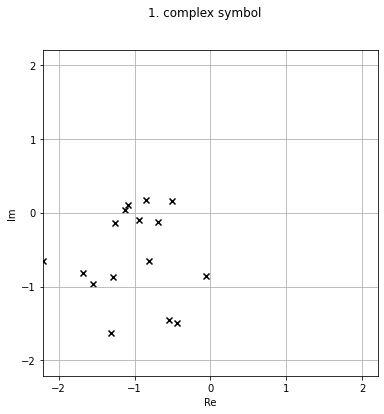

In [ ]:
plot_constellation();

#### Bit-Labeling for each AE message
Label each of the M messages with a sequence of k bit (groud-truth labels)

In [ ]:
def get_bit_label_natural(k):
    M=2**k
    label_natural = np.zeros((M,k))

    for j in range(M):
        for i in range(k):
            label_natural[j,i] = np.binary_repr(j, width = k)[i]
    return label_natural

L = tf.cast(get_bit_label_natural(k),dtype=tf.int8)
print(L.numpy())

[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]


#### Initial constellation with labels

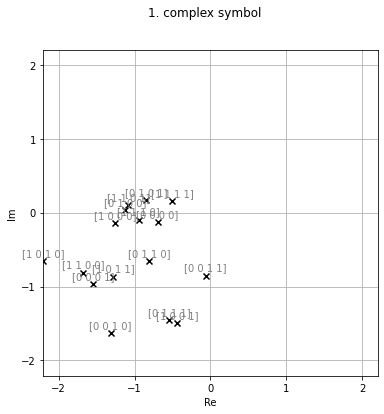

In [ ]:
plot_constellation(show_labels=True);

### Channel 
Use the trained CGAN as a surrogate for the real channel during training. Use the awgn_channel to test performance of trained autoencoder

In [ ]:
def ebnodb_2_noisestd(awgn_ebno_db):
    return  1.0 / tf.sqrt(k/n * 2 * 10**(awgn_ebno_db/10.))  # noise variance per complex-valued component

def awgn_channel(x,awgn_ebno_db):
    noise_std = ebnodb_2_noisestd(awgn_ebno_db)
    return x + tf.random.normal(shape=tf.shape(x)) * tf.cast(noise_std,dtype=tf.float32)

### The Decoder / Receiver

In [ ]:
decoder_input = tf.keras.Input(shape=(n), name='dec_in')
x = tf.keras.layers.Dense(128,activation="relu")(decoder_input)
x = tf.keras.layers.Dense(128,activation="relu")(x)
decoder_output = tf.keras.layers.Dense(k,activation=None)(x)
decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_in (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 516       
Total params: 17,412
Trainable params: 17,412
Non-trainable params: 0
_________________________________________________________________


### Training
**Things to implement/do**
*   Training vs Validation Loss/Accuracy Graph
*   Early Stopping
*   Training with low EbNo vs high EbNo
*   Training with long sequences 


In [ ]:
optimizer = tf.keras.optimizers.RMSprop(1e-4)

In [ ]:
def autoencode(batch_size,awgn_ebno_db):
    s = tf.random.uniform(shape=(batch_size,),minval=0,maxval=M,dtype=tf.int32)
    u = tf.gather(L,s)
    
    x = encoder(s)
    y, z_mean, z_log_var, z = vae(x)
    # y = vae.layers[10](vae.layers[9](vae.layers[8](vae.layers[7](x))))
    #
    #
    u_l = decoder(y)
    
    return u,u_l

#to test with real channel
def autoencode_test(batch_size,awgn_ebno_db):
    s = tf.random.uniform(shape=(batch_size,),minval=0,maxval=M,dtype=tf.int32)
    u = tf.gather(L,s)
    
    x = encoder(s)
    y = awgn_channel(x,awgn_ebno_db)
    u_l = decoder(y)
    
    return u,u_l

@tf.function
def train_step(batch_size,awgn_ebno_db):
    
    with tf.GradientTape() as tape:
        u,u_l = autoencode(batch_size,awgn_ebno_db)
        # Loss
        loss = tf.losses.binary_crossentropy(y_true=u,y_pred=-u_l,from_logits=True)

    trainable_weights = [] + encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_weights)
    # Applying gradients for this batch
    optimizer.apply_gradients(zip(gradients, trainable_weights))
    
    return tf.reduce_mean(loss)

@tf.function
def test_step(batch_size,awgn_ebno_db):
    u,u_l = autoencode(batch_size,awgn_ebno_db)
    
    # AE Performance metrics
    u_hat_hard = tf.cast(tf.less(u_l,0.0),tf.int8)
    correct_predictions = tf.equal(u_hat_hard,u)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    ber_hard = 1.0 - accuracy
    
    return ber_hard

#used with autoencode_test
def test_step_2(batch_size,awgn_ebno_db):
    u,u_l = autoencode_test(batch_size,awgn_ebno_db)
    
    # AE Performance metrics
    u_hat_hard = tf.cast(tf.less(u_l,0.0),tf.int8)
    correct_predictions = tf.equal(u_hat_hard,u)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    ber_hard = 1.0 - accuracy
    
    return ber_hard 
#
def validation_loss(batch_size,awgn_ebno_db):
    u,u_l = autoencode_test(batch_size,awgn_ebno_db)
    loss = tf.losses.binary_crossentropy(y_true=u,y_pred=-u_l,from_logits=True)
    return tf.reduce_mean(loss)

def validation_GAN_loss(batch_size,awgn_ebno_db):
    u,u_l = autoencode(batch_size,awgn_ebno_db)
    loss = tf.losses.binary_crossentropy(y_true=u,y_pred=-u_l,from_logits=True)
    return tf.reduce_mean(loss)

def plot_training_validation_loss(loss):
    '''Plot the training loss vs validation'''
    image = plt.figure(figsize=(10,8))
    #this wont give an error if you change the training params but it wont be right anymore
    #need to change the epoch upper limit if training params are changed
    epoch = np.linspace(0,3.9,np.size(loss,0))
    plt.plot(epoch, loss[:,0], '-r', linewidth=2.0)
    plt.plot(epoch, loss[:,1], '-g', linewidth=2.0)
    # plt.plot(epoch, loss[:,2], '-b', linewidth=2.0)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.grid(True)
    plt.yscale('log')
    image.axes[0].set_xticks(np.array([0,1,2,3,4]))
    #plt.ylim([1e-5,1])
    plt.legend(['Training',  'Validation']);#,'Validation Real Channel']);
    return 

In [ ]:
def train(training_params, validation_params):  
    '''Training and validation loop'''
    losses = np.empty([40,3])
    for index, params in enumerate(training_params):
        batch_size, lr, ebnodb, iterations = params
        print('\nBatch Size: ' + str(batch_size) +
              ', Learning Rate: ' + str(lr) +
              ', EbNodB: ' + str(ebnodb) +
              ', Iterations: ' + str(iterations))

        val_size, val_ebnodb, val_steps = validation_params[index]

        for i in range(iterations):
            optimizer.learning_rate = lr
            loss = train_step(tf.constant(batch_size), tf.constant(ebnodb)).numpy()
            if (i%val_steps==0):
                #ber = test_step(val_size,val_ebnodb).numpy()
                #changed this so that the evaluation is done using the test set (awgn channel not the VAE channel)
                ber = test_step(val_size,val_ebnodb).numpy()
                val_loss = validation_loss(val_size,val_ebnodb).numpy()
                val_loss_GAN = validation_GAN_loss(val_size,val_ebnodb).numpy()
                losses[index*10+i//val_steps] = loss, val_loss_GAN, val_loss 
                print("loss: %.3e    BER: %.3e" % (loss,ber))
    return losses

def ber_sim(ebnodbs, batch_size, iterations):
    '''Monte Carlo simulations of BER for a range of Eb/No
       Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
       You can average over multiple batches with small size instead.           
    '''
    BER = np.zeros_like(ebnodbs)
    for i in range(iterations):
        ber = np.array([test_step_2(tf.constant(batch_size), tf.constant(ebnodb)).numpy() for ebnodb in ebnodbs])
        #print(ber);
        BER = BER + ber/iterations
    return BER

def plot_ber(EbNodB, BER):
    '''Plot a BER vs SNR curve'''
    image = plt.figure(figsize=(10,8))
    plt.plot(EbNodB, BER, '-r', linewidth=2.0)
    plt.yscale('log')
    plt.xlabel('EbNo (dB)', fontsize=18)
    plt.ylabel('Bit-error rate', fontsize=18)
    plt.grid(True)
    plt.ylim([1e-5,1])
    return image






#### Training parameters

Here we define the SNR during training. The autoencoder will then be trained to find an optimal constellation for this specific training SNR.
Mind that this constellation might not be the optimal constellation for the total SNR range, also the receiver is only trained to demap at training SNR.

In [ ]:
train_EbNodB = 15.0
val_EbNodB = train_EbNodB

training_params = [
    #batch_size, lr, ebnodb, iterations
    [100    , 0.001, train_EbNodB, 1000],
    [1000    , 0.0001, train_EbNodB, 1000],
    [10000    , 0.0001, train_EbNodB, 1000],
    [100000    , 0.0001, train_EbNodB, 1000]
]


validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 100]
]

#### Train

In [ ]:
losses = train(training_params,validation_params)


Batch Size: 100, Learning Rate: 0.001, EbNodB: 15.0, Iterations: 1000
loss: 6.970e-01    BER: 5.159e-01
loss: 2.318e-01    BER: 9.142e-02
loss: 1.329e-01    BER: 5.300e-02
loss: 3.942e-02    BER: 4.275e-04
loss: 5.967e-03    BER: 1.252e-05
loss: 1.472e-03    BER: 2.503e-06
loss: 2.507e-03    BER: 6.747e-05
loss: 1.109e-04    BER: 0.000e+00
loss: 5.452e-05    BER: 2.503e-06
loss: 9.230e-05    BER: 7.510e-06

Batch Size: 1000, Learning Rate: 0.0001, EbNodB: 15.0, Iterations: 1000
loss: 1.442e-04    BER: 0.000e+00
loss: 1.205e-05    BER: 0.000e+00
loss: 9.153e-06    BER: 0.000e+00
loss: 5.069e-06    BER: 0.000e+00
loss: 4.332e-06    BER: 0.000e+00
loss: 3.378e-06    BER: 0.000e+00
loss: 2.672e-06    BER: 0.000e+00
loss: 2.374e-06    BER: 0.000e+00
loss: 1.931e-06    BER: 0.000e+00
loss: 1.458e-06    BER: 0.000e+00

Batch Size: 10000, Learning Rate: 0.0001, EbNodB: 15.0, Iterations: 1000
loss: 2.454e-06    BER: 0.000e+00
loss: 2.467e-06    BER: 0.000e+00
loss: 9.890e-07    BER: 0.000e+00


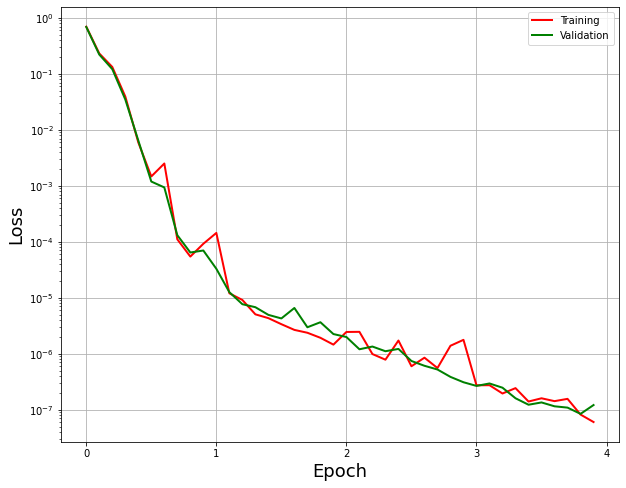

In [ ]:
plot_training_validation_loss(losses)

In [ ]:
print(losses)
#print(losses[:,0])

[[6.96951807e-01 6.89103305e-01 6.89048648e-01]
 [2.31754303e-01 2.21399143e-01 2.23092973e-01]
 [1.32910848e-01 1.21574841e-01 1.23406678e-01]
 [3.94234248e-02 3.49431634e-02 3.93341482e-02]
 [5.96704381e-03 6.45501446e-03 8.46195966e-03]
 [1.47180574e-03 1.19278056e-03 2.05011317e-03]
 [2.50721583e-03 9.36979195e-04 1.79310353e-03]
 [1.10907211e-04 1.31246095e-04 3.21001746e-04]
 [5.45158182e-05 6.44668980e-05 3.10440897e-04]
 [9.22955660e-05 6.99834272e-05 3.46790475e-04]
 [1.44238162e-04 3.29945651e-05 1.08662272e-04]
 [1.20453951e-05 1.26147106e-05 1.26308878e-04]
 [9.15307010e-06 7.68648715e-06 6.07147595e-05]
 [5.06865172e-06 6.79471259e-06 5.61543420e-05]
 [4.33165496e-06 4.95694803e-06 6.54948963e-05]
 [3.37757456e-06 4.27929808e-06 4.24443351e-05]
 [2.67156861e-06 6.57898499e-06 4.51551714e-05]
 [2.37435756e-06 2.97657721e-06 3.71393908e-05]
 [1.93060509e-06 3.66131894e-06 5.59418950e-05]
 [1.45764693e-06 2.25117651e-06 2.29370471e-05]
 [2.45387741e-06 1.99348142e-06 5.216157

### Evaluation

The found constellation afte training

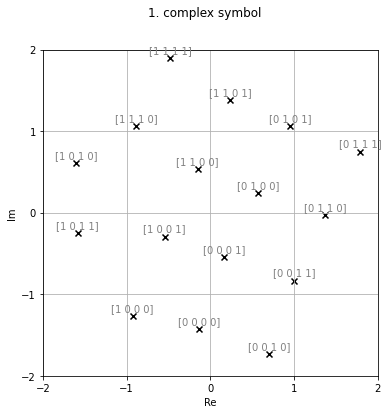

In [ ]:
plot_constellation(show_labels=True);

#### BER perfomance evaluation
AE's BER performance vs classical baselines.
The baseline results are taken from our webdemo [Physical Layer Performance Measures - Symbol Error Rate, BER and Mutual Information](https://webdemo.inue.uni-stuttgart.de/webdemos/02_lectures/communication_3/performance_measures/).

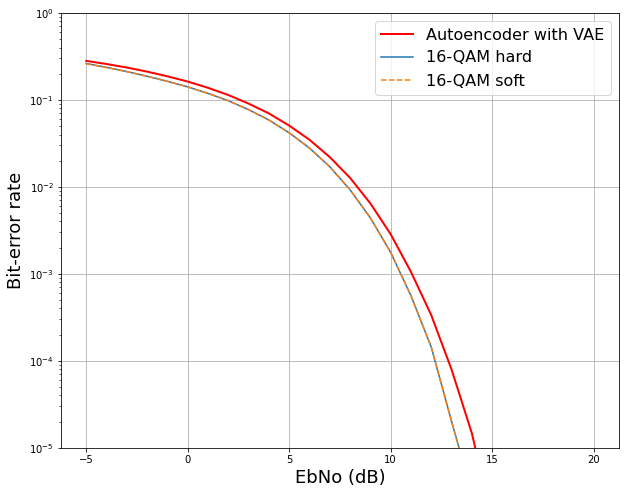

In [ ]:
# reference curves
ebnodbs_ref = np.linspace(-5,20,26)
ber_ref_hard_n2 = np.array([[2.132e-01, 1.861e-01, 1.588e-01, 1.303e-01, 1.037e-01, 7.823e-02, 5.592e-02, 3.737e-02, 2.282e-02, 1.249e-02, 5.959e-03, 2.385e-03, 7.400e-04, 2.050e-04, 3.500e-05, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.137e-01, 1.857e-01, 1.581e-01, 1.310e-01, 1.042e-01, 7.860e-02, 5.629e-02, 3.746e-02, 2.302e-02, 1.241e-02, 5.978e-03, 2.387e-03, 7.570e-04, 2.010e-04, 3.600e-05, 5.000e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.713e-01, 2.474e-01, 2.231e-01, 1.966e-01, 1.697e-01, 1.426e-01, 1.152e-01, 8.909e-02, 6.482e-02, 4.411e-02, 2.738e-02, 1.539e-02, 7.492e-03, 3.011e-03, 1.000e-03, 2.537e-04, 4.100e-05, 2.667e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.618e-01, 2.367e-01, 2.116e-01, 1.872e-01, 1.636e-01, 1.411e-01, 1.187e-01, 9.781e-02, 7.725e-02, 5.876e-02, 4.186e-02, 2.795e-02, 1.704e-02, 9.262e-03, 4.407e-03, 1.768e-03, 5.617e-04, 1.443e-04, 2.025e-05, 3.000e-06, 5.000e-07, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])
ber_ref_soft_n2 = np.array([[2.132e-01, 1.861e-01, 1.588e-01, 1.303e-01, 1.037e-01, 7.823e-02, 5.592e-02, 3.737e-02, 2.282e-02, 1.249e-02, 5.959e-03, 2.385e-03, 7.400e-04, 2.050e-04, 3.500e-05, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.137e-01, 1.858e-01, 1.582e-01, 1.309e-01, 1.043e-01, 7.858e-02, 5.627e-02, 3.746e-02, 2.301e-02, 1.241e-02, 5.978e-03, 2.387e-03, 7.570e-04, 2.010e-04, 3.600e-05, 5.000e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.655e-01, 2.423e-01, 2.188e-01, 1.932e-01, 1.674e-01, 1.410e-01, 1.143e-01, 8.866e-02, 6.462e-02, 4.401e-02, 2.734e-02, 1.537e-02, 7.492e-03, 3.011e-03, 9.997e-04, 2.537e-04, 4.100e-05, 2.667e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.600e-01, 2.356e-01, 2.110e-01, 1.869e-01, 1.635e-01, 1.410e-01, 1.187e-01, 9.781e-02, 7.725e-02, 5.876e-02, 4.186e-02, 2.795e-02, 1.704e-02, 9.262e-03, 4.407e-03, 1.768e-03, 5.617e-04, 1.443e-04, 2.025e-05, 3.000e-06, 5.000e-07, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])
ber_ref_theory_n2 = np.array([[2.132e-01, 1.861e-01, 1.584e-01, 1.306e-01, 1.038e-01, 7.865e-02, 5.628e-02, 3.751e-02, 2.288e-02, 1.250e-02, 5.954e-03, 2.388e-03, 7.727e-04, 1.909e-04, 3.363e-05, 3.872e-06, 2.613e-07, 9.006e-09, 1.333e-10, 6.810e-13, 9.124e-16, 2.267e-19, 6.759e-24, 1.396e-29, 1.001e-36, 1.044e-45],[2.132e-01, 1.861e-01, 1.584e-01, 1.306e-01, 1.038e-01, 7.865e-02, 5.628e-02, 3.751e-02, 2.288e-02, 1.250e-02, 5.954e-03, 2.388e-03, 7.727e-04, 1.909e-04, 3.363e-05, 3.872e-06, 2.613e-07, 9.006e-09, 1.333e-10, 6.810e-13, 9.124e-16, 2.267e-19, 6.759e-24, 1.396e-29, 1.001e-36, 1.044e-45],[3.491e-01, 3.162e-01, 2.814e-01, 2.452e-01, 2.081e-01, 1.712e-01, 1.355e-01, 1.023e-01, 7.282e-02, 4.821e-02, 2.917e-02, 1.578e-02, 7.423e-03, 2.931e-03, 9.298e-04, 2.241e-04, 3.827e-05, 4.239e-06, 2.724e-07, 8.827e-09, 1.209e-10, 5.603e-13, 6.640e-16, 1.414e-19, 3.470e-24, 5.611e-30],[3.075e-01, 2.863e-01, 2.633e-01, 2.387e-01, 2.127e-01, 1.855e-01, 1.578e-01, 1.301e-01, 1.032e-01, 7.816e-02, 5.586e-02, 3.716e-02, 2.262e-02, 1.233e-02, 5.854e-03, 2.339e-03, 7.529e-04, 1.849e-04, 3.231e-05, 3.684e-06, 2.456e-07, 8.334e-09, 1.210e-10, 6.030e-13, 7.832e-16, 1.872e-19]])

# autoencoder simulations
ebnodbs = np.linspace(-5,20,26)
bers = ber_sim(ebnodbs, 100000, 10);#set number of itterations to 10
#print(bers);
plot_ber(ebnodbs, bers);

plt.plot(ebnodbs_ref,ber_ref_hard_n2[k-1]);
plt.plot(ebnodbs_ref,ber_ref_soft_n2[k-1],"--");
# plt.plot(ebnodbs_ref,ber_ref_theory_n2[k-1],"--");

plt.legend(['Autoencoder with VAE', '%d-QAM hard' % M,'%d-QAM soft' % M, 'closed-form approx.'], prop={'size': 16}, loc='upper right');

### Things to improve upon
Training vs Validation Loss Graph
It is a standard practice to show training vs validation loss/accuracy graph to illustrate whether the learning-based model generalizes well or if it overfits/underfit. We will implement this and put it in our report

Illustrate that when trained with low EbNos, the model has diffculty learning the optimal constellation that generalizes well across a wide range of EbNos. We can interpret this as using inaccurate ground-truth labels in a supervised learning task, and the model is unable to learn the general relationship between the input and output.